In [21]:
#Importing Libraries
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h2>Loading Data

In [23]:
#Dataset Path
train_dir = 'C:/Users/reddy/OneDrive/Desktop/HELLO/22 ML Projects/Plant Disease Detection Model/PlantVillage' 

In [24]:
# Data augmentation and generator setup (with 20% validation split)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 44371 images belonging to 39 classes.
Found 11077 images belonging to 39 classes.


In [25]:
# Dynamically determine the number of classes from the folder structure
num_classes = len(train_generator.class_indices)
print("Number of classes in the dataset:", num_classes)

Number of classes in the dataset: 39


<h2>Transfer Learning

In [26]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  # Freeze the base model initially

In [27]:
model = Sequential([
    base_model,
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer now has 39 units
])

In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
# Define callbacks for early stopping and saving the best model.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

In [30]:
# Initial training phase: train only the top layers.
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
1386/1386 [==============================] - 736s 527ms/step - loss: 1.5794 - accuracy: 0.5542 - val_loss: 0.6429 - val_accuracy: 0.8168
Epoch 2/30
1386/1386 [==============================] - 329s 238ms/step - loss: 0.9745 - accuracy: 0.6991 - val_loss: 0.4784 - val_accuracy: 0.8583
Epoch 3/30
1386/1386 [==============================] - 310s 224ms/step - loss: 0.8566 - accuracy: 0.7344 - val_loss: 0.4178 - val_accuracy: 0.8640
Epoch 4/30
1386/1386 [==============================] - 294s 212ms/step - loss: 0.7879 - accuracy: 0.7562 - val_loss: 0.3845 - val_accuracy: 0.8748
Epoch 5/30
1386/1386 [==============================] - 299s 216ms/step - loss: 0.7624 - accuracy: 0.7631 - val_loss: 0.3746 - val_accuracy: 0.8776
Epoch 6/30
1386/1386 [==============================] - 296s 213ms/step - loss: 0.7291 - accuracy: 0.7726 - val_loss: 0.3599 - val_accuracy: 0.8960
Epoch 7/30
1386/1386 [==============================] - 293s 212ms/step - loss: 0.7126 - accuracy: 0.7817 - val_

<h2>Fine-Tuning

In [31]:
#Freezing 1st 100 layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [32]:
# Recompile the model with a lower learning rate for fine-tuning.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
# Fine-tune the model for additional epochs.
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,  # Adjust epochs as needed based on validation performance.
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
1386/1386 [==============================] - 472s 338ms/step - loss: 0.5684 - accuracy: 0.8251 - val_loss: 0.2660 - val_accuracy: 0.9210
Epoch 2/10
1386/1386 [==============================] - 479s 345ms/step - loss: 0.5374 - accuracy: 0.8342 - val_loss: 0.2553 - val_accuracy: 0.9259
Epoch 3/10
1386/1386 [==============================] - 504s 363ms/step - loss: 0.5321 - accuracy: 0.8365 - val_loss: 0.2597 - val_accuracy: 0.9237
Epoch 4/10
1386/1386 [==============================] - 507s 366ms/step - loss: 0.5200 - accuracy: 0.8393 - val_loss: 0.2604 - val_accuracy: 0.9254
Epoch 5/10
1386/1386 [==============================] - 563s 406ms/step - loss: 0.5191 - accuracy: 0.8405 - val_loss: 0.2531 - val_accuracy: 0.9242
Epoch 6/10
1386/1386 [==============================] - 509s 367ms/step - loss: 0.5231 - accuracy: 0.8379 - val_loss: 0.2597 - val_accuracy: 0.9262
Epoch 7/10
1386/1386 [==============================] - 548s 395ms/step - loss: 0.5153 - accuracy: 0.8405 - val_

In [34]:
print("Training complete. Best model saved as 'best_model.h5'.")

Training complete. Best model saved as 'best_model.h5'.


<h2>Examples

1/1 [==============================] - 0s 27ms/step


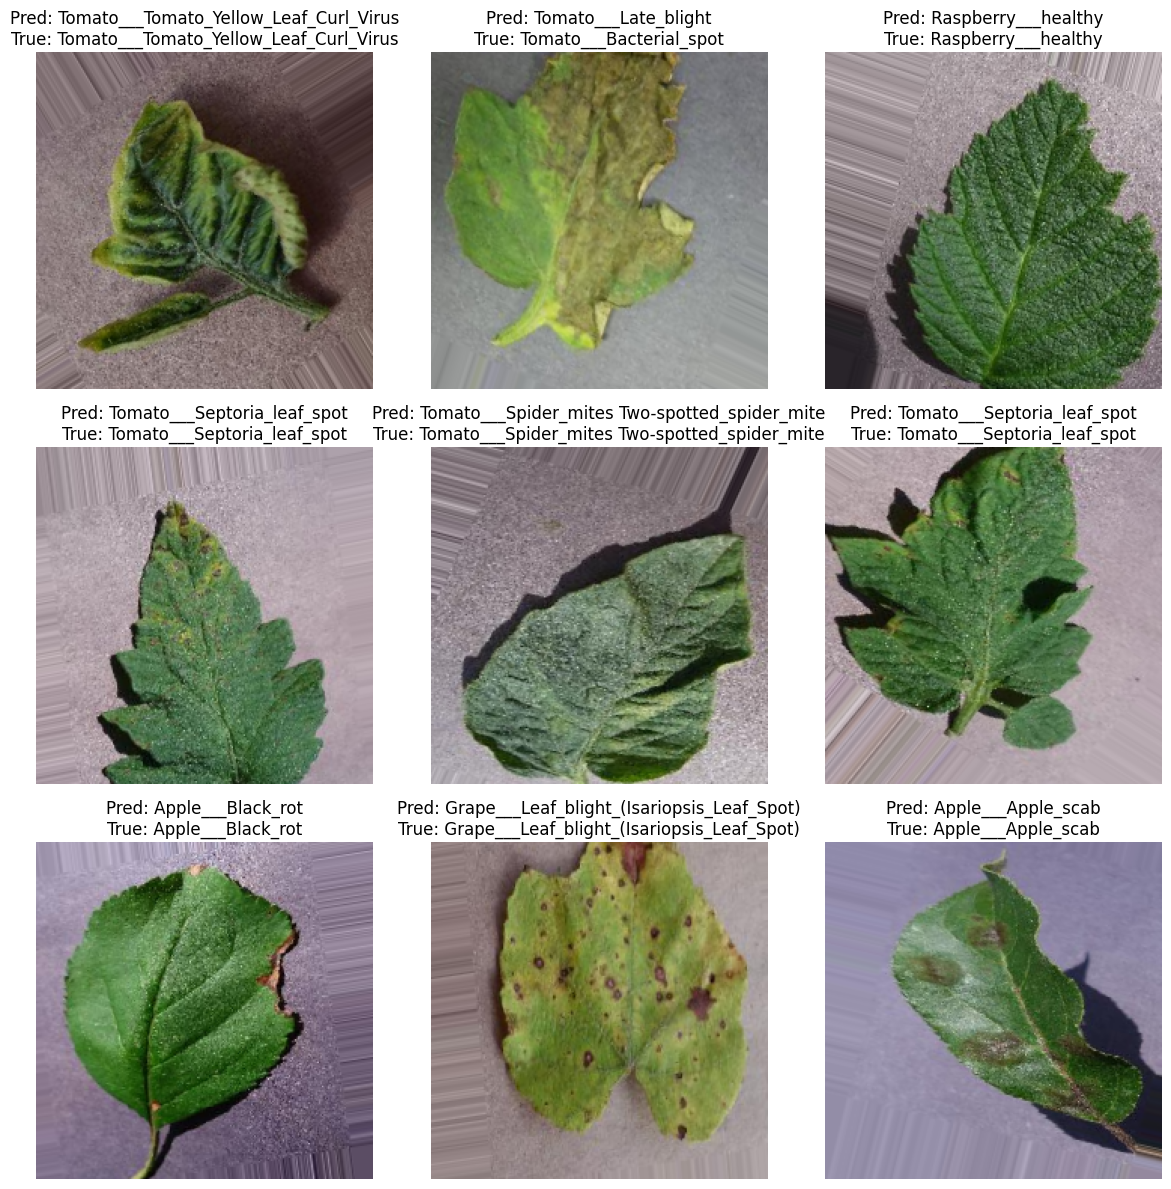

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Get a single batch of images and labels from the validation generator.
# If you prefer, you could also use your training generator or load images from disk.
x_val, y_val = next(val_generator)

# Use the trained model to predict the classes for these images.
predictions = model.predict(x_val)

# Convert the prediction probabilities into class labels (indices).
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Retrieve class names from the training generator's mapping.
# This assumes that your train_generator was set up to automatically map folder names to indices.
class_indices = train_generator.class_indices
# Invert the dictionary to map indices back to class names.
class_names = {v: k for k, v in class_indices.items()}

# Plot a grid of 9 sample images along with their predicted and true labels.
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_val[i])
    plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[true_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
